# Evaluate eyeballing and auto-garbaging policies

Here we use the test sets as a proxy eyeball list to see how applying our eyeballing and auto-garbaging policies fairs. 

The current strategy is as follows:
* Eyeball everything with VRA rank >=4
* On day1 Garbage anything with VRA rank <1.5
* On the secnd visit garbage anything with maximum VRA rank <3
* On subsequent visits garbage anything with mean VRA rank <3.



In [1]:
%load_ext autoreload
%autoreload 2

from atlasvras.utils.prettify import vra_colors, label_to_color
import matplotlib.pyplot as plt
import pandas as pd 
from glob import glob
from joblib import load
from tqdm.notebook import tqdm
import numpy as np

dict_type_to_preal = {'garbage': 0,
                      'pm': 0,
                      'galactic': 1,
                      'good': 1
                     }

dict_type_to_pgal = {'garbage': 0,
                      'pm': 1,
                      'galactic': 1,
                      'good': 0
                     }

############## PLOT STYLE ################
# Comment out if you don't have the file
plt.style.use('vra')
##########################################

#############################################################
#    ____         __        ____                          
#   / __/_ _____ / /  ___ _/ / /                          
#  / _// // / -_) _ \/ _ `/ / /                           
# /___/\_, /\__/_.__/\_,_/_/_/                            
#     /___/       ________               __        __   __
#                /_  __/ /  _______ ___ / /  ___  / /__/ /
#                 / / / _ \/ __/ -_|_-</ _ \/ _ \/ / _  / 
#                /_/ /_//_/_/  \__/___/_//_/\___/_/\_,_/  
#
#
EYEBALL_THRESHOLD = 4
#
##############################################################

## Loading the data 

In [2]:
RELATIVE_PATH_DAY1 = './data/features_and_labels_csv/day1/'
RELATIVE_PATH_UPDATE = './data/features_and_labels_csv/update/'

In [3]:
# "Day1" data
X_test_unbalanced_DAY1 = pd.read_csv(f'{RELATIVE_PATH_DAY1}X_test_unbalanced_randomsplit.csv', index_col=0)
y_test_unbalanced_DAY1 = pd.read_csv(f'{RELATIVE_PATH_DAY1}y_test_unbalanced_randomsplit.csv', index_col=0)

In [4]:
#  "Update" data 
X_test_unbalanced_UPDATE = pd.read_csv(f'{RELATIVE_PATH_UPDATE}X_test_unbalanced.csv', index_col=0)
y_test_unbalanced_UPDATE = pd.read_csv(f'{RELATIVE_PATH_UPDATE}y_test_unbalanced.csv', index_col=0)

## Loading and running the best models (according to the AuRaK in our HP tuning)

In [5]:
real_scorer_DAY1 = load('./train_scoring_models/hyperparameter_tuning/hp_tuning_day1/models/real_scorer_LR0.1_L210.0_randomsplit.joblib')
gal_scorer_DAY1 = load('./train_scoring_models/hyperparameter_tuning/hp_tuning_day1/models/gal_scorer_LR0.2_L210.0_randomsplit.joblib')

real_scorer_UPDATE = load('./train_scoring_models/hyperparameter_tuning/hp_tuning_update/models/real_scorer_LR0.1_L21.0_randomsplit.joblib')
gal_scorer_UPDATE =load('./train_scoring_models/hyperparameter_tuning/hp_tuning_update/models/gal_scorer_LR0.1_L210.0_randomsplit.joblib')

In [6]:
## Calculating the Real and Galactic scores for the Day 1 models
REAL_PRED_DAY1 = real_scorer_DAY1.predict_proba(X_test_unbalanced_DAY1).T[1]
GAL_PRED_DAY1 = gal_scorer_DAY1.predict_proba(X_test_unbalanced_DAY1).T[1]

## Calculating the Real and Galactic Scores for the Update models
REAL_PRED_UPDATE = real_scorer_UPDATE.predict_proba(X_test_unbalanced_UPDATE).T[1]
GAL_PRED_UPDATE = gal_scorer_UPDATE.predict_proba(X_test_unbalanced_UPDATE).T[1]

### Calculating the ranks

In [7]:

def rank_df(df, fudge_factor=0.4, max_score=10):
    "Rank function that can be used in DataFrame.apply() to create the ranks column"
    REAL_PRED, GAL_PRED = df.preal, df.pgal
    ranks = np.sqrt((1-REAL_PRED)**2 + fudge_factor*(GAL_PRED)**2)
    max_distance = np.sqrt(fudge_factor**2 + 1.0)
    return ((max_distance - ranks) * max_score) / max_distance

In [8]:
y_test_unbalanced_DAY1['preal'] = REAL_PRED_DAY1
y_test_unbalanced_DAY1['pgal'] = GAL_PRED_DAY1
y_test_unbalanced_DAY1['ranks'] =  y_test_unbalanced_DAY1.apply(rank_df, axis=1)

In [9]:
y_test_unbalanced_UPDATE['preal'] = REAL_PRED_UPDATE
y_test_unbalanced_UPDATE['pgal'] = GAL_PRED_UPDATE
y_test_unbalanced_UPDATE['ranks'] =  y_test_unbalanced_UPDATE.apply(rank_df, axis=1)

In [10]:
y_test_unbalanced_UPDATE

,type,preal,pgal,ranks
ATLAS_ID,,,,
1182934220174131200,garbage,0.112160,0.576037,1.089589
1182934220174131200,garbage,0.140250,0.669861,1.100876
1182934220174131200,garbage,0.116282,0.587092,1.100039
1182934220174131200,garbage,0.122911,0.638254,1.035354
1182934220174131200,garbage,0.123954,0.587092,1.165669
...,...,...,...,...
1184704250083934200,garbage,0.314915,0.738287,2.302213
1184704250083934200,garbage,0.424392,0.801401,2.878986
1174519880265007100,garbage,0.159523,0.743515,1.058008


### Adding the "counts" column to the "update" data set

We are interested in evaluating the deleting policies and eyeballing policies after each telescope visit.
For the Day 1 data, it is the first visit (since entering eyealling list) so no need to keep track.
For the update data, each object is seen several times, and we need to keep track.
We also need to account for the fact that **a visit has already occured** (in the day 1 data set), and python starts counting at zero, so when we do our cumulative count we **add +2**.

In [11]:
y_test_unbalanced_UPDATE['counts'] = (y_test_unbalanced_UPDATE.reset_index().groupby('ATLAS_ID')['ATLAS_ID'].transform('cumcount')+2).values

In [12]:
y_test_unbalanced_UPDATE

,type,preal,pgal,ranks,counts
ATLAS_ID,,,,,
1182934220174131200,garbage,0.112160,0.576037,1.089589,2
1182934220174131200,garbage,0.140250,0.669861,1.100876,3
1182934220174131200,garbage,0.116282,0.587092,1.100039,4
1182934220174131200,garbage,0.122911,0.638254,1.035354,5
1182934220174131200,garbage,0.123954,0.587092,1.165669,6
...,...,...,...,...,...
1184704250083934200,garbage,0.314915,0.738287,2.302213,9
1184704250083934200,garbage,0.424392,0.801401,2.878986,10
1174519880265007100,garbage,0.159523,0.743515,1.058008,2


# Evaluating the policies, after each visit

Eyeballing threshold is the same all the time, but the auto-garbaging is dependent on how many visits have occured.



## Day 1 policies

**Delete all alerts with rank less than 1.5**

In [13]:
DELETE_DAY1_THRESHOLD = 1.5

In [14]:
df_autogarbage_day1 = y_test_unbalanced_DAY1[y_test_unbalanced_DAY1.ranks.values<DELETE_DAY1_THRESHOLD]

Text(0.5, 1.0, 'Deleted Day 1  (N=3408)')

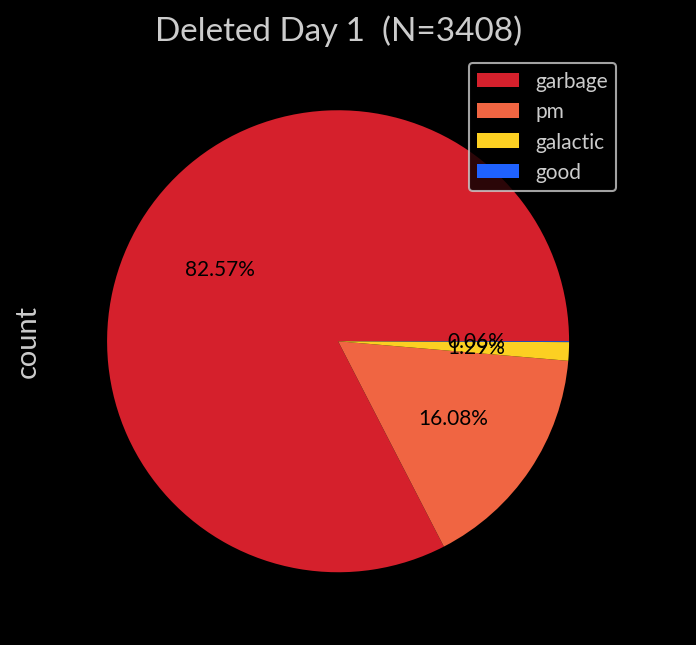

In [15]:
df = df_autogarbage_day1 ['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Deleted Day 1  (N={df.sum()})')

### what good alerts get deleted and is it "acceptable" losses

In [16]:
df_autogarbage_day1[df_autogarbage_day1.type=='good']

,type,preal,pgal,ranks
ATLAS_ID,,,,
1225835351364240100,good,0.099715,0.567363,1.001566
1014421750500135200,good,0.146839,0.551267,1.442678




- https://star.pst.qub.ac.uk/sne/atlas4/candidate/1225835351364240100/: **No idea why that would rank badly it real space! should rnak high! [UNACCEPTABLE]**
- https://star.pst.qub.ac.uk/sne/atlas4/candidate/1014421750500135200/: **Genuinely bad -> acceptable**

Text(0.5, 1.0, 'Eyeballed Day 1  (N=1147)')

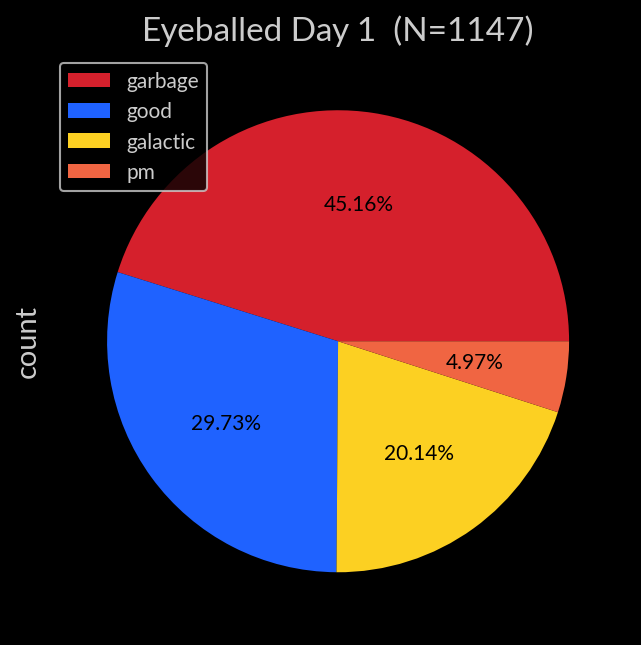

In [17]:
df_eyeball_day1 = y_test_unbalanced_DAY1[y_test_unbalanced_DAY1.ranks.values>=EYEBALL_THRESHOLD]
df = df_eyeball_day1['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)
plt.title(f'Eyeballed Day 1  (N={df.sum()})')

Text(0.5, 1.0, 'Purgatory Day 1  (N=1566)')

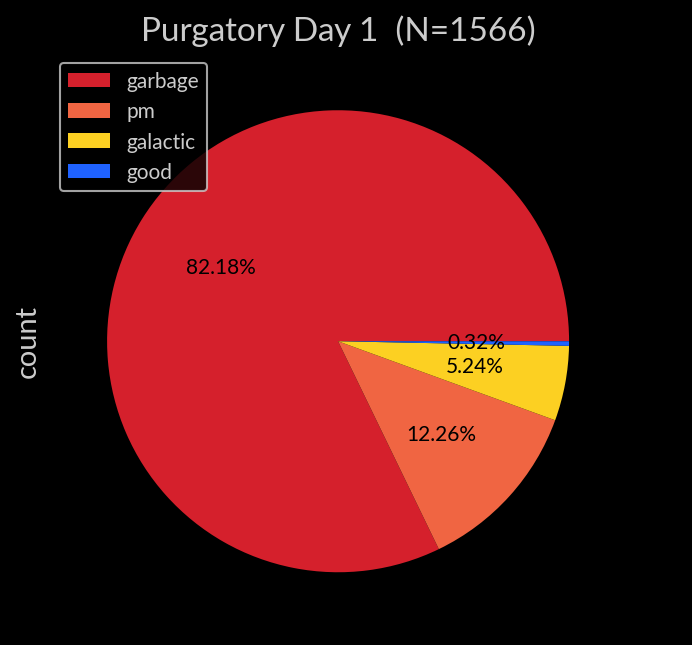

In [18]:
df_purgatory_day1 = y_test_unbalanced_DAY1[(y_test_unbalanced_DAY1.ranks.values<EYEBALL_THRESHOLD)
                            &(y_test_unbalanced_DAY1.ranks.values>DELETE_DAY1_THRESHOLD)
                           ]
df = df_purgatory_day1['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)
plt.title(f'Purgatory Day 1  (N={df.sum()})')

In [19]:
print("First visit:")
print("N total: %.i" % (y_test_unbalanced_DAY1.shape[0]))
print("N auto-garbaged: %.i " % (df_autogarbage_day1.shape[0]) )
print("N eyeballed: %.i " % (df_eyeball_day1.shape[0]) )
print("N in purgatory: %.i " % (df_purgatory_day1.shape[0]) )

First visit:
N total: 6121
N auto-garbaged: 3408 
N eyeballed: 1147 
N in purgatory: 1566 


In [20]:
print("First visit:")
print("Fraction auto-garbaged: %.2f " % (df_autogarbage_day1.shape[0]/y_test_unbalanced_DAY1.shape[0]) )
print("Fraction eyeballed: %.2f " % (df_eyeball_day1.shape[0]/y_test_unbalanced_DAY1.shape[0]) )
print("Fraction in purgatory: %.2f " % (df_purgatory_day1.shape[0]/y_test_unbalanced_DAY1.shape[0]) )

First visit:
Fraction auto-garbaged: 0.56 
Fraction eyeballed: 0.19 
Fraction in purgatory: 0.26 


##  Second visit policies

Now we need to look at the **updater models** behaviour. 
We have made sure when creating the data sets that the objects in the test set for the Day 1 models are the same in the Update models.

All the test objects in the Update test data set are in the Day 1 set

In [21]:
 set(y_test_unbalanced_UPDATE.index.get_level_values(0))-set(y_test_unbalanced_DAY1.index)

set()

Although note, that not all the test objects in Day 1 test set are in the update data set, because they just won't have had visits within 15 days of t=entering the eyeball list.

In [22]:
set(y_test_unbalanced_DAY1.index)-set(y_test_unbalanced_UPDATE.index.get_level_values(0))

{1024648031555211100,
 1025623711614258100,
 1032847520464805800,
 1043006480370744600,
 1043829541685039900,
 1045026390460509200,
 1050304210082155200,
 1053536921030126500,
 1071915990353940100,
 1074406000135116100,
 1075704740572216700,
 1080944560163146000,
 1082239750211121200,
 1082729910561600300,
 1092157081562649200,
 1101453770230258300,
 1103842950503224000,
 1110112930395536000,
 1122708971712400100,
 1143202600190511300,
 1143916500174720400,
 1193004091140451900,
 1193029090055253500,
 1204808441023650100,
 1223434831752132100,
 1230508190452824000}

### Removing all objects eyeballed and garbaged on day 1

In [23]:
set_left_over_day2 = set(df_purgatory_day1.index)

In [24]:
## since not all objects in Day 1 test set are in the Update set then we need to 
# take the intersection of the left over indexes with the indexes present in our data frame
mask = list(set_left_over_day2.intersection(set(y_test_unbalanced_UPDATE.index.get_level_values(0))))

In [25]:
left_over_day2 = y_test_unbalanced_UPDATE.loc[mask]

### Creating the data frame only containing samples with 2 visits
Our left over data set contains several samples per ATLAS object: 

In [26]:
left_over_day2

,type,preal,pgal,ranks,counts
ATLAS_ID,,,,,
1204026810160742400,garbage,0.314513,0.784190,2.144224,2
1204026810160742400,garbage,0.327532,0.784190,2.241832,3
1204026810160742400,garbage,0.320263,0.780000,2.201886,4
1204026810160742400,garbage,0.395052,0.780000,2.752396,5
1204026810160742400,garbage,0.391228,0.768792,2.766103,6
...,...,...,...,...,...
1211022710541615100,garbage,0.068919,0.149749,1.310524,2
1211022710541615100,garbage,0.072676,0.147285,1.346678,3
1211022710541615100,garbage,0.075486,0.143212,1.375009,4


We only care about objects that have been seen twice so we crop the data frame accordingly 

In [27]:
count2_eyeball = left_over_day2[left_over_day2.counts <= 2]

In [28]:
count2_eyeball

,type,preal,pgal,ranks,counts
ATLAS_ID,,,,,
1204026810160742400,garbage,0.314513,0.784190,2.144224,2
1075053310332829700,garbage,0.445246,0.380074,4.386481,2
1002806810655342600,garbage,0.073060,0.137674,1.355688,2
1215550780152135700,pm,0.144142,0.837633,0.654410,2
1231015320255619100,garbage,0.184429,0.550771,1.765845,2
...,...,...,...,...,...
1175746600274911200,garbage,0.125618,0.283513,1.712625,2
1130432930195734500,garbage,0.105838,0.325887,1.480217,2
1022111781515354100,garbage,0.183218,0.772735,1.162478,2


In [29]:
count2_eyeball.index.get_level_values(0).shape[0]

1554

### 2nd visit garbaging policy: max rank <3 

We want to garbage the objects who've not had a rank>3 on their first or second visit. 
To do this we find the set of IDs in day 1 purgatory with ranks <3, and the set of IDs with 
updated ranks <3 and take the intersection. 

In [30]:
DELETE_DAY2_THRESHOLD = 3

In [31]:
ids_to_delete = list(set(count2_eyeball[count2_eyeball.ranks<DELETE_DAY2_THRESHOLD].index.get_level_values(0)).intersection(set(df_purgatory_day1[df_purgatory_day1.ranks<DELETE_DAY2_THRESHOLD].index)))

In [32]:
df_autogarbage_visit2 = count2_eyeball.loc[ids_to_delete]

Text(0.5, 1.0, 'Deleted 2nd Visit  (N=1117)')

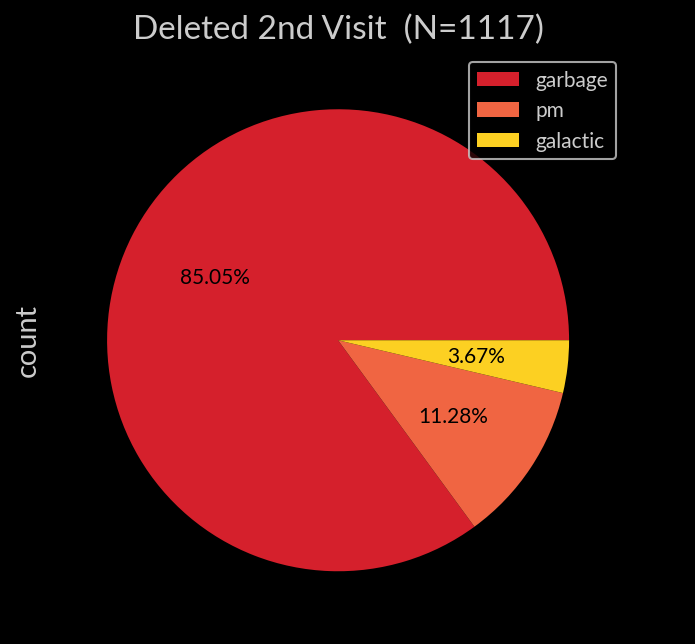

In [33]:
df = df_autogarbage_visit2['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Deleted 2nd Visit  (N={df.sum()})')

In [34]:
df_eyeball_visit2 = count2_eyeball[(count2_eyeball.ranks.values>EYEBALL_THRESHOLD)]

Text(0.5, 1.0, 'Eyeball 2nd Visit  (N=77)')

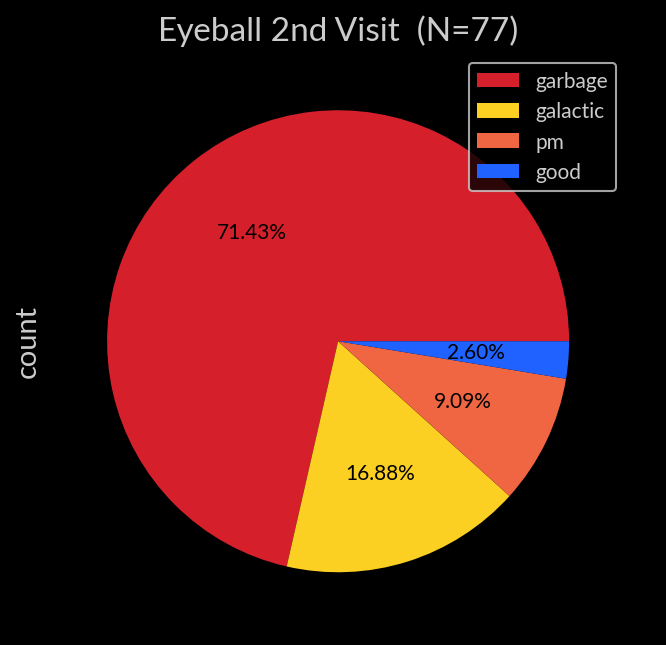

In [35]:
df = df_eyeball_visit2['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Eyeball 2nd Visit  (N={df.sum()})')

In [36]:
ids_purgatory_visit2 = list(set(count2_eyeball.index.get_level_values(0))-set(df_eyeball_visit2.index.get_level_values(0)).union(set(df_autogarbage_visit2.index.get_level_values(0))))

Text(0.5, 1.0, 'Purgatory Day 2 (N=360)')

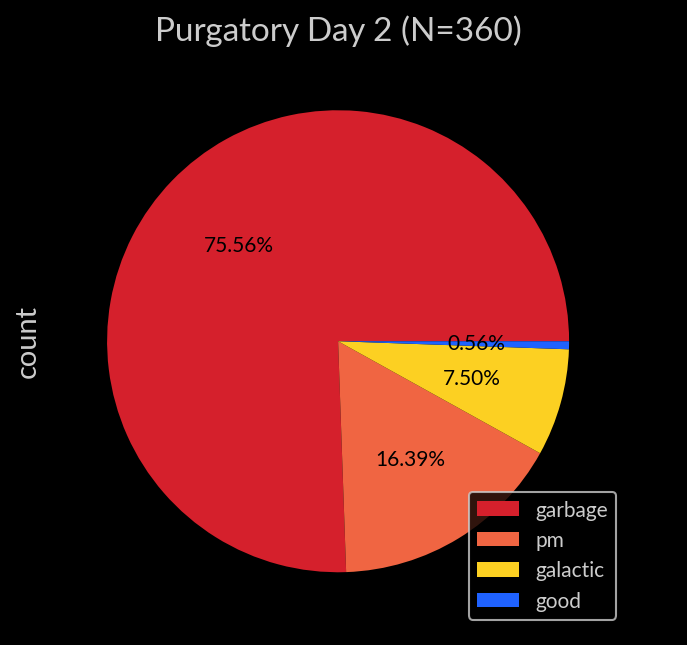

In [37]:
df_purgatory_visit2 =  count2_eyeball.loc[ids_purgatory_visit2]
df = df_purgatory_visit2['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)
plt.title(f'Purgatory Day 2 (N={df.sum()})')

In [38]:
print("Second visit:")
print("N total: %.i" % (count2_eyeball.shape[0]))
print("N auto-garbaged: %.i " % (df_autogarbage_visit2.shape[0]) )
print("N eyeballed: %.i " % (df_eyeball_visit2.shape[0]) )
print("N in purgatory: %.i " % (df_purgatory_visit2.shape[0]) )

Second visit:
N total: 1554
N auto-garbaged: 1117 
N eyeballed: 77 
N in purgatory: 360 


In [39]:
print("Second visit:")
print("Fraction auto-garbaged: %.2f " % (df_autogarbage_visit2.shape[0]/count2_eyeball.shape[0]) )
print("Fraction eyeballed: %.2f " % (df_eyeball_visit2.shape[0]/count2_eyeball.shape[0]) )
print("Fraction in purgatory: %.2f " % (df_purgatory_visit2.shape[0]/count2_eyeball.shape[0]) )

Second visit:
Fraction auto-garbaged: 0.72 
Fraction eyeballed: 0.05 
Fraction in purgatory: 0.23 


## 3rd visit 

In [40]:
left_over_day2

,type,preal,pgal,ranks,counts
ATLAS_ID,,,,,
1204026810160742400,garbage,0.314513,0.784190,2.144224,2
1204026810160742400,garbage,0.327532,0.784190,2.241832,3
1204026810160742400,garbage,0.320263,0.780000,2.201886,4
1204026810160742400,garbage,0.395052,0.780000,2.752396,5
1204026810160742400,garbage,0.391228,0.768792,2.766103,6
...,...,...,...,...,...
1211022710541615100,garbage,0.068919,0.149749,1.310524,2
1211022710541615100,garbage,0.072676,0.147285,1.346678,3
1211022710541615100,garbage,0.075486,0.143212,1.375009,4


In [41]:
set_left_over_day3 = set(left_over_day2.index.get_level_values(0)) - set(df_eyeball_visit2.index.get_level_values(0)).union(set(df_autogarbage_visit2.index.get_level_values(0)))
left_over_day3 = left_over_day2.loc[list(set_left_over_day3)]

In [42]:
left_over_day3

,type,preal,pgal,ranks,counts
ATLAS_ID,,,,,
1184024440073834500,garbage,0.632635,0.862778,3.892404,2
1184024440073834500,garbage,0.636226,0.867685,3.886967,3
1184024440073834500,garbage,0.609259,0.863736,3.764017,4
1184024440073834500,garbage,0.606358,0.863736,3.748309,5
1184024440073834500,garbage,0.606358,0.863736,3.748309,6
...,...,...,...,...,...
1133715520635848700,garbage,0.115931,0.492073,1.297880,2
1133715520635848700,garbage,0.106635,0.516660,1.167867,3
1133715520635848700,garbage,0.114877,0.492073,1.288648,4


In [43]:
count3_eyeball = left_over_day3[left_over_day3.counts==3]

In [44]:
count3_eyeball = count3_eyeball.join(
    df_purgatory_visit2.ranks, rsuffix="_day2").join(
    y_test_unbalanced_DAY1.ranks, rsuffix="_day1"
)

In [45]:
count3_eyeball

,type,preal,pgal,ranks,counts,ranks_day2,ranks_day1
ATLAS_ID,,,,,,,
1184024440073834500,garbage,0.636226,0.867685,3.886967,3,3.892404,3.647135
1205208701010849800,garbage,0.200428,0.387610,2.235069,3,2.127762,3.480591
1123457930365200400,garbage,0.235217,0.069883,2.887323,3,3.247959,2.848113
1222031610432630800,garbage,0.155602,0.482854,1.662983,3,1.676040,3.769234
1030212241270958100,galactic,0.230470,0.352467,2.561349,3,2.461383,3.894789
...,...,...,...,...,...,...,...
1150550740314310600,garbage,0.140411,0.194186,1.937864,3,2.190899,3.785896
1195339191215642600,garbage,0.422223,0.550218,3.737620,3,3.512215,3.651482
1022111781515354100,garbage,0.101077,0.772743,0.499936,3,1.162478,3.867839


In [46]:
DELETE_DAY3_MEANTHRESHOLD = 3

In [47]:
## make function to do mean of ranks that can be used in .apply 

In [48]:
def mean_rank_3visits(df):
    return (df.ranks + df.ranks_day2 + df.ranks_day1)/3

In [49]:
count3_eyeball['mean_rank'] = count3_eyeball.apply(mean_rank_3visits, axis=1)

In [50]:
count3_eyeball

,type,preal,pgal,ranks,counts,ranks_day2,ranks_day1,mean_rank
ATLAS_ID,,,,,,,,
1184024440073834500,garbage,0.636226,0.867685,3.886967,3,3.892404,3.647135,3.808835
1205208701010849800,garbage,0.200428,0.387610,2.235069,3,2.127762,3.480591,2.614474
1123457930365200400,garbage,0.235217,0.069883,2.887323,3,3.247959,2.848113,2.994465
1222031610432630800,garbage,0.155602,0.482854,1.662983,3,1.676040,3.769234,2.369419
1030212241270958100,galactic,0.230470,0.352467,2.561349,3,2.461383,3.894789,2.972507
...,...,...,...,...,...,...,...,...
1150550740314310600,garbage,0.140411,0.194186,1.937864,3,2.190899,3.785896,2.638220
1195339191215642600,garbage,0.422223,0.550218,3.737620,3,3.512215,3.651482,3.633772
1022111781515354100,garbage,0.101077,0.772743,0.499936,3,1.162478,3.867839,1.843418


In [51]:
ids_to_delete_visit3 = count3_eyeball.mean_rank[count3_eyeball.mean_rank<DELETE_DAY3_MEANTHRESHOLD].index.get_level_values(0)

Text(0.5, 1.0, 'Deleted 3nd Visit  (N=208)')

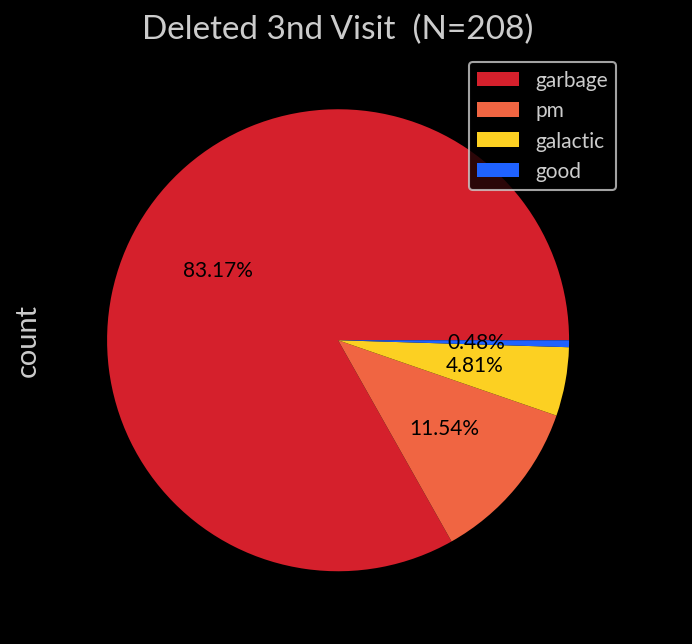

In [52]:
df_autogarbage_visit3 = count3_eyeball.loc[ids_to_delete_visit3]
df= df_autogarbage_visit3['type'].value_counts()
df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Deleted 3nd Visit  (N={df.sum()})')

In [53]:
df_autogarbage_visit3[df_autogarbage_visit3.type=='good']

,type,preal,pgal,ranks,counts,ranks_day2,ranks_day1,mean_rank
ATLAS_ID,,,,,,,,
1023055171305157200,good,0.323891,0.713588,2.452413,3,2.189205,3.069789,2.570469


https://star.pst.qub.ac.uk/sne/atlas4/candidate/1023055171305157200/: **Tail end of a SN... we'd hope to catch this, talk to steve about this too**


Text(0.5, 1.0, 'Eyeball 3nd Visit  (N=22)')

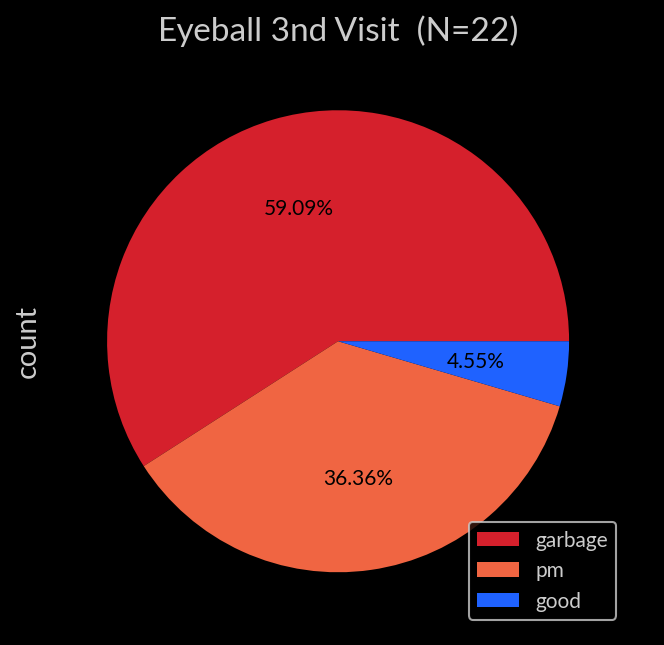

In [54]:
df_eyeball_visit3= count3_eyeball[(count3_eyeball.ranks.values>EYEBALL_THRESHOLD)
                      ]
df = df_eyeball_visit3['type'].value_counts()


df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Eyeball 3nd Visit  (N={df.sum()})')

In [55]:
ids_purgatory_visit3 = list(set(count3_eyeball.index.get_level_values(0))-set(df_eyeball_visit3.index.get_level_values(0)).union(set(df_autogarbage_visit3.index.get_level_values(0))))

Text(0.5, 1.0, 'Purgatory Day 3 (N=123)')

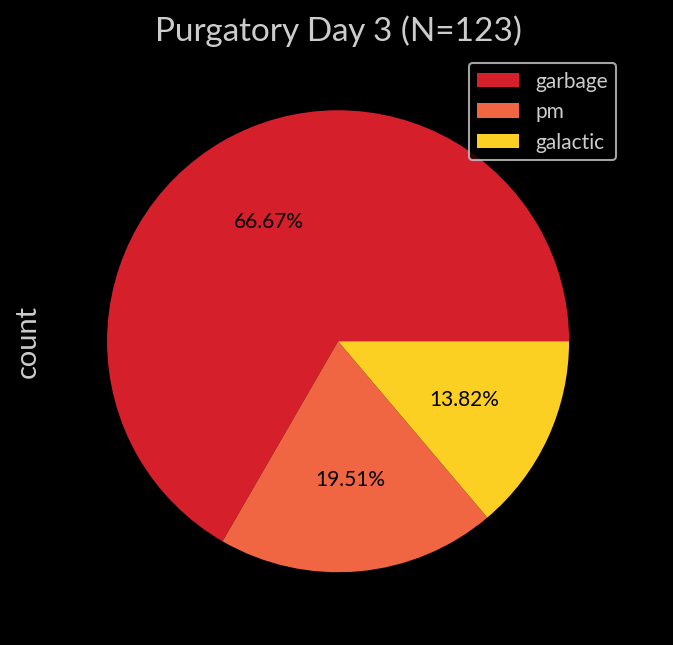

In [56]:
df_purgatory_visit3 =  count3_eyeball.loc[ids_purgatory_visit3]
df = df_purgatory_visit3['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)
plt.title(f'Purgatory Day 3 (N={df.sum()})')

In [57]:
print("Third visit:")
print("N total: %.i" % (count3_eyeball.shape[0]))
print("N auto-garbaged: %.i " % (df_autogarbage_visit3.shape[0]) )
print("N eyeballed: %.i " % (df_eyeball_visit3.shape[0]) )
print("N in purgatory: %.i " % (df_purgatory_visit3.shape[0]) )

Third visit:
N total: 353
N auto-garbaged: 208 
N eyeballed: 22 
N in purgatory: 123 


In [58]:
print("Third visit:")
print("Fraction auto-garbaged: %.2f " % (df_autogarbage_visit3.shape[0]/count3_eyeball.shape[0]) )
print("Fraction eyeballed: %.2f " % (df_eyeball_visit3.shape[0]/count3_eyeball.shape[0]) )
print("Fraction in purgatory: %.2f " % (df_purgatory_visit3.shape[0]/count3_eyeball.shape[0]) )

Third visit:
Fraction auto-garbaged: 0.59 
Fraction eyeballed: 0.06 
Fraction in purgatory: 0.35 


### 4th visit 

In [59]:
set_left_over_day4 = set(left_over_day3.index.get_level_values(0)) - set(df_eyeball_visit3.index.get_level_values(0)).union(set(df_autogarbage_visit3.index.get_level_values(0)))
left_over_day4 = left_over_day3.loc[list(set_left_over_day4)]

In [60]:
left_over_day4

,type,preal,pgal,ranks,counts
ATLAS_ID,,,,,
1184024440073834500,garbage,0.632635,0.862778,3.892404,2
1184024440073834500,garbage,0.636226,0.867685,3.886967,3
1184024440073834500,garbage,0.609259,0.863736,3.764017,4
1184024440073834500,garbage,0.606358,0.863736,3.748309,5
1184024440073834500,garbage,0.606358,0.863736,3.748309,6
...,...,...,...,...,...
1154645420423816700,galactic,0.424301,0.647555,3.440189,3
1154645420423816700,galactic,0.410145,0.648914,3.328102,4
1154645420423816700,galactic,0.359665,0.648914,2.938297,5


In [61]:
count4_eyeball = left_over_day4[left_over_day4.counts==4]

In [62]:
count4_eyeball = count4_eyeball.join( df_purgatory_visit3.ranks, rsuffix='_day3'
                                    ).join( df_purgatory_visit2.ranks, rsuffix="_day2"
                                          ).join(y_test_unbalanced_DAY1.ranks, rsuffix="_day1"
                                                )


In [63]:
count4_eyeball

,type,preal,pgal,ranks,counts,ranks_day3,ranks_day2,ranks_day1
ATLAS_ID,,,,,,,,
1184024440073834500,garbage,0.609259,0.863736,3.764017,4,3.886967,3.892404,3.647135
1180548920253439500,garbage,0.265717,0.473486,2.637194,4,3.158346,3.496301,3.493454
1175003500243856400,garbage,0.384664,0.526425,3.504066,4,3.515660,3.586717,3.032921
1013711620331237400,pm,0.265539,0.372852,2.837836,4,2.967712,3.349436,3.369820
1182142370230232100,garbage,0.461356,0.527359,4.117671,4,2.654041,2.832579,3.935388
...,...,...,...,...,...,...,...,...
1173813590234509800,garbage,0.499734,0.702119,3.789232,4,3.469813,3.608268,1.926100
1195339191215642600,garbage,0.400253,0.550305,3.561757,4,3.737620,3.512215,3.651482
1182547330211038700,garbage,0.345250,0.376992,3.530265,4,3.885419,3.885419,3.163729


In [64]:
def mean_rank_4visits(df):
    return (df.ranks + df.ranks_day3 + df.ranks_day2 + df.ranks_day1)/4

count4_eyeball['mean_rank'] = count4_eyeball.apply(mean_rank_4visits, axis=1)

In [65]:
ids_to_delete_visit4 = count4_eyeball.mean_rank[count4_eyeball.mean_rank<DELETE_DAY3_MEANTHRESHOLD].index.get_level_values(0)

Text(0.5, 1.0, 'Deleted 4th Visit  (N=14)')

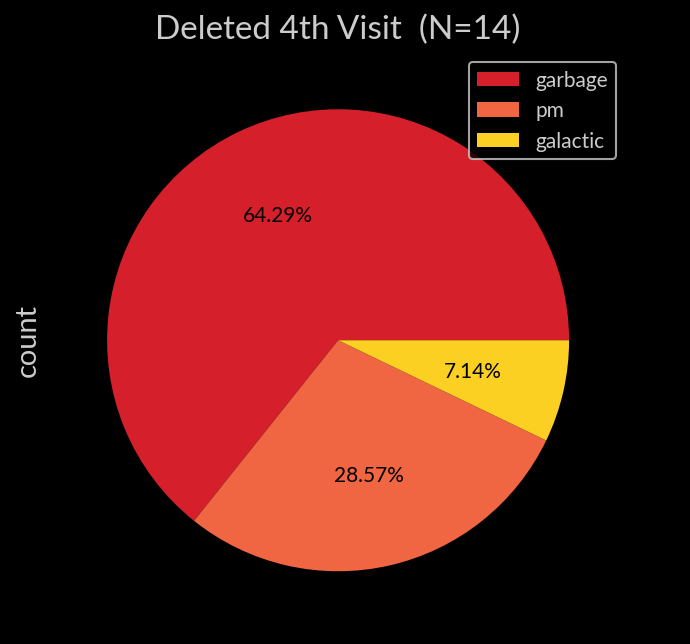

In [66]:
df_autogarbage_visit4 = count4_eyeball.loc[ids_to_delete_visit4]
df= df_autogarbage_visit4['type'].value_counts()
df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Deleted 4th Visit  (N={df.sum()})')

Text(0.5, 1.0, 'Eyeball 4th Visit  (N=9)')

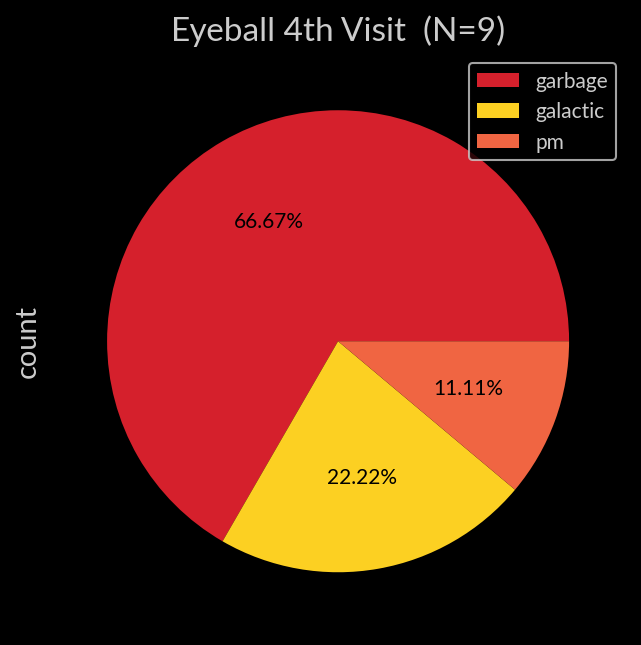

In [67]:
df_eyeball_visit4= count4_eyeball[(count4_eyeball.ranks.values>EYEBALL_THRESHOLD)
                      ]
df = df_eyeball_visit4['type'].value_counts()


df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Eyeball 4th Visit  (N={df.sum()})')

In [68]:
ids_purgatory_visit4 = list(set(count4_eyeball.index.get_level_values(0))-set(df_eyeball_visit4.index.get_level_values(0)).union(set(df_autogarbage_visit4.index.get_level_values(0))))

Text(0.5, 1.0, 'Purgatory Day 4 (N=96)')

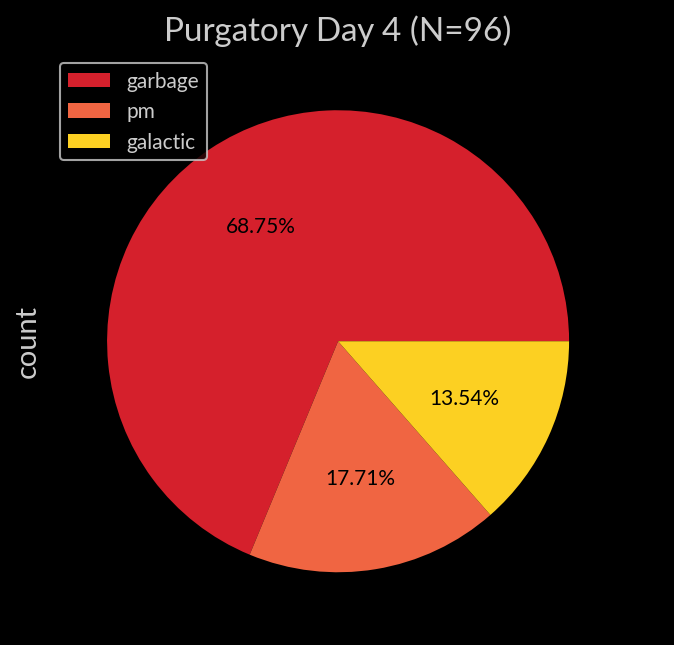

In [69]:
df_purgatory_visit4 =  count4_eyeball.loc[ids_purgatory_visit4]
df = df_purgatory_visit4['type'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)
plt.title(f'Purgatory Day 4 (N={df.sum()})')

In [70]:
print("Fourth visit:")
print("N total: %.i" % (count4_eyeball.shape[0]))
print("N auto-garbaged: %.i " % (df_autogarbage_visit4.shape[0]) )
print("N eyeballed: %.i " % (df_eyeball_visit4.shape[0]) )
print("N in purgatory: %.i " % (df_purgatory_visit4.shape[0]) )

Fourth visit:
N total: 119
N auto-garbaged: 14 
N eyeballed: 9 
N in purgatory: 96 


## What's left? What did we miss and why?
In eyeballing we never get to a fifth visit, decisions are made before that in general. 

So what's left here

In [71]:
set_left_over = set(left_over_day4.index.get_level_values(0)) - set(df_eyeball_visit4.index.get_level_values(0)).union(set(df_autogarbage_visit4.index.get_level_values(0)))
left_over = left_over_day4.loc[list(set_left_over)]

Text(0.5, 1.0, 'Left over after 4 visits(N=107)')

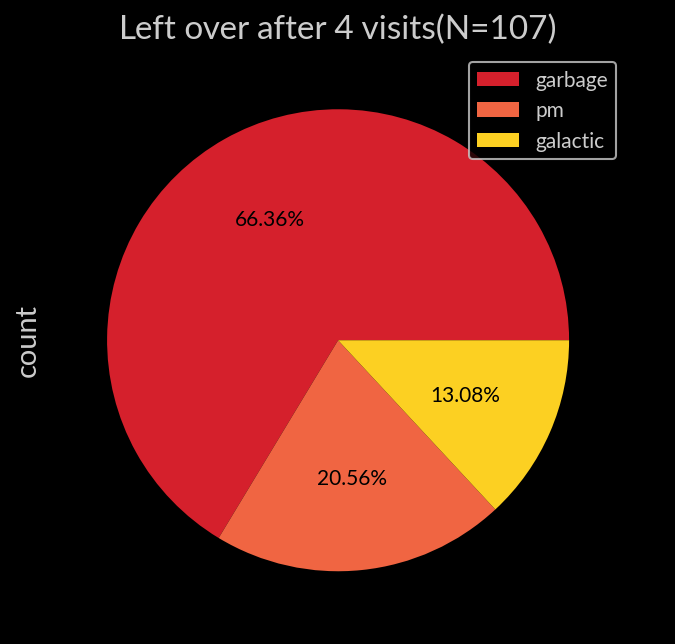

In [72]:
df = left_over.reset_index('ATLAS_ID').drop_duplicates('ATLAS_ID',keep='first').type.value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)
plt.title(f'Left over after 4 visits(N={df.sum()})')

## What percentage is left behind "not garbaged, not eyeballed"

In [73]:
df/y_test_unbalanced_UPDATE.reset_index('ATLAS_ID').drop_duplicates('ATLAS_ID',keep='first').type.value_counts()*100

type
galactic    3.943662
garbage     1.543143
good             NaN
pm          2.774275
Name: count, dtype: float64

In [74]:
N_garbaged = (df_autogarbage_day1.type.value_counts()
                  + df_autogarbage_visit2.type.value_counts()
                  + df_autogarbage_visit3.type.value_counts()
               + df_autogarbage_visit4.type.value_counts()
                 )

In [75]:
N_garbaged/y_test_unbalanced_UPDATE.reset_index('ATLAS_ID').drop_duplicates('ATLAS_ID',keep='first').type.value_counts()*100

type
galactic    27.042254
garbage     85.763964
good              NaN
pm          88.524590
Name: count, dtype: float64

In [76]:
left_over[left_over.type=='good'].index.get_level_values(0).unique()

Index([], dtype='int64', name='ATLAS_ID')

In [77]:
list_ids = left_over[left_over.type=='good'].index.get_level_values(0).unique()
for _id in list_ids:
    print(f'- [{_id}](https://star.pst.qub.ac.uk/sne/atlas4/candidate/{_id})')

# Overall performance after 4 visits

In [78]:
garbaged_alert_types = pd.concat((df_autogarbage_day1.type,
                                  df_autogarbage_visit2.type,
                                  df_autogarbage_visit3.type,
                                  df_autogarbage_visit4.type,
                                 )
                                )

Text(0.5, 1.0, 'Garbaged (N=4747)')

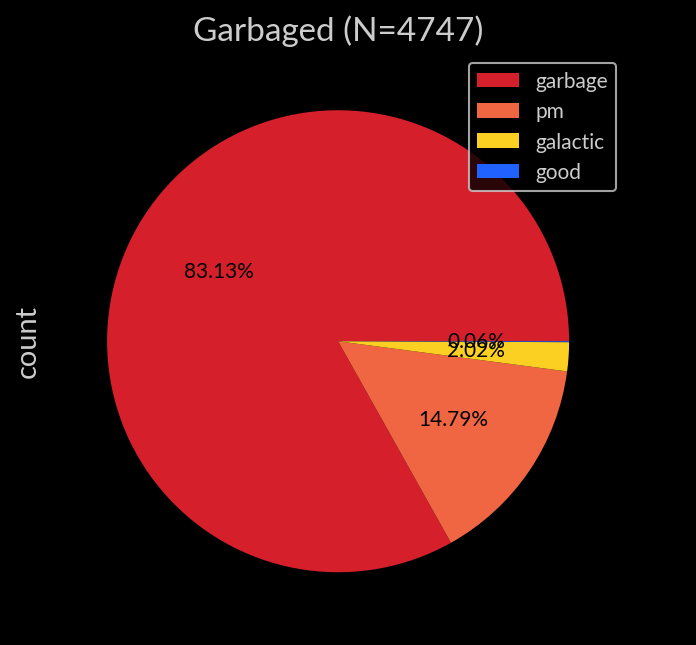

In [79]:
df = garbaged_alert_types.value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Garbaged (N={df.sum()})')

In [80]:
eyeballed_alert_types = pd.concat((df_eyeball_day1.type,
                                  df_eyeball_visit2.type,
                                  df_eyeball_visit3.type,
                                  df_eyeball_visit4.type,
                                 )
                                )

Text(0.5, 1.0, 'Eyeballed(N=1255)')

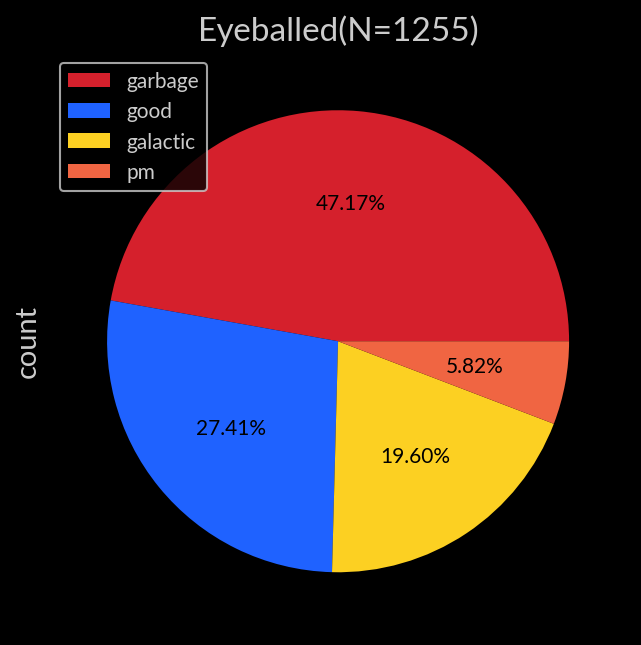

In [81]:
df = eyeballed_alert_types .value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[label_to_color[label] for label in df.index.values], legend=True)

plt.title(f'Eyeballed(N={df.sum()})')

In [82]:
garbaged_alert_types = pd.DataFrame(garbaged_alert_types)
garbaged_alert_types['vra_outcome'] = 'garbaged'



In [83]:
eyeballed_alert_types =  pd.DataFrame(eyeballed_alert_types)
eyeballed_alert_types['vra_outcome'] = 'eyeballed'

In [84]:
y_test_unbalanced_DAY1 = y_test_unbalanced_DAY1.join(pd.concat((garbaged_alert_types.vra_outcome,
                                                                eyeballed_alert_types.vra_outcome)))

In [85]:
y_test_unbalanced_DAY1.vra_outcome.fillna('purgatory', inplace=True)

/tmp/ipykernel_344867/4025510066.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_test_unbalanced_DAY1.vra_outcome.fillna('purgatory', inplace=True)


Text(0.5, 1.0, 'VRA outcome Good Objects (N=348)')

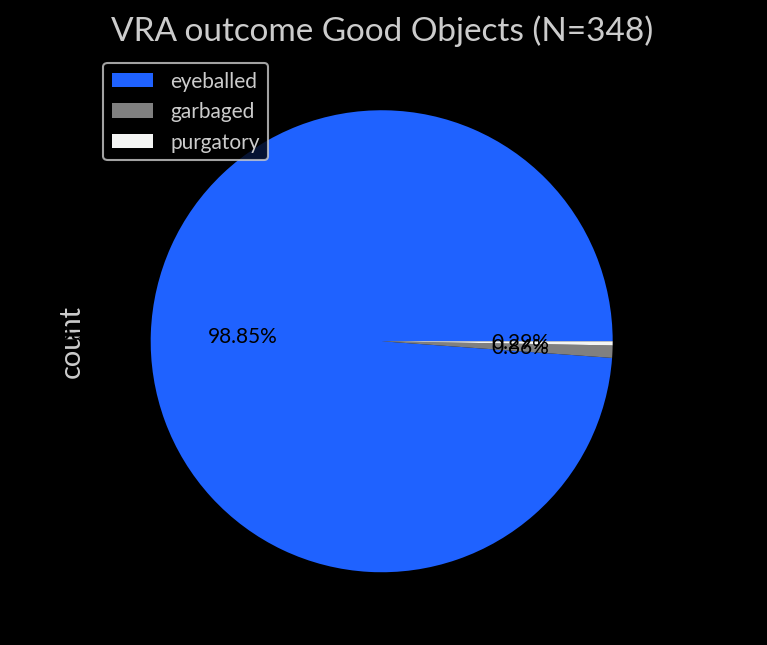

In [86]:
dict_color = {'garbaged': 'grey',
              'eyeballed': vra_colors['blue'],
              'purgatory': vra_colors['white']
             }
mask_good = y_test_unbalanced_DAY1.type =='good'
df = y_test_unbalanced_DAY1[mask_good]['vra_outcome'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[dict_color[label] for label in df.index.values], legend=True)

plt.title(f'VRA outcome Good Objects (N={df.sum()})')

Text(0.5, 1.0, 'VRA outcome Galactic Objects (N=357)')

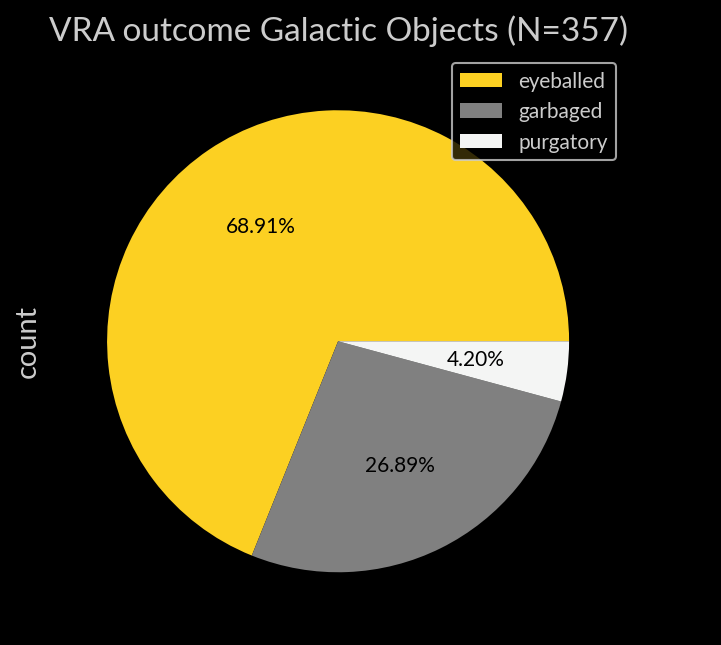

In [87]:
dict_color = {'garbaged': 'grey',
              'eyeballed': vra_colors['yellow'],
              'purgatory': vra_colors['white']
             }
mask_good = y_test_unbalanced_DAY1.type =='galactic'
df = y_test_unbalanced_DAY1[mask_good]['vra_outcome'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[dict_color[label] for label in df.index.values], legend=True)

plt.title(f'VRA outcome Galactic Objects (N={df.sum()})')

In [88]:
y_test_unbalanced_DAY1[mask_good]['vra_outcome']

ATLAS_ID
1162355201192657000    eyeballed
1105802070493921400    eyeballed
1171214830293549200    purgatory
1172529120301449500    eyeballed
1195739540203340100    eyeballed
                         ...    
1171926990342848100     garbaged
1194112510201528000    eyeballed
1000318650192723700    eyeballed
1131120800241844000    eyeballed
1122347030463348700    eyeballed
Name: vra_outcome, Length: 357, dtype: object

Text(0.5, 1.0, 'VRA outcome Garbage or PM (N=5416)')

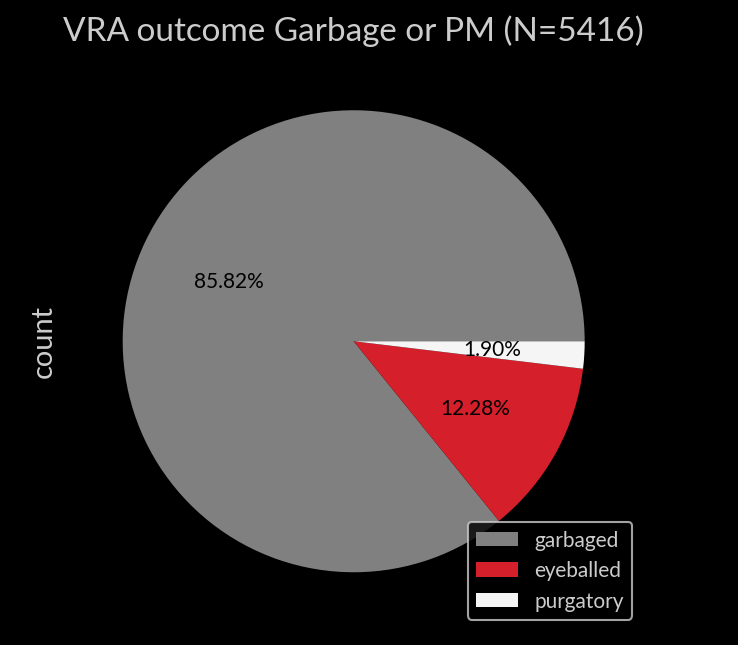

In [89]:
dict_color = {'garbaged': 'grey',
              'eyeballed': vra_colors['red'],
              'purgatory': vra_colors['white']
             }
mask_good = (y_test_unbalanced_DAY1.type =='garbage') | (y_test_unbalanced_DAY1.type =='pm') 
df = y_test_unbalanced_DAY1[mask_good]['vra_outcome'].value_counts()

df.plot(kind='pie',autopct = "%.2f%%", textprops={'color':'k'},
                           colors=[dict_color[label] for label in df.index.values], legend=True)

plt.title(f'VRA outcome Garbage or PM (N={df.sum()})')